# Applying SDG labels to publications

This script makes use of the Open SDG project (https://osdg.ai/) and (https://github.com/osdg-ai/osdg-tool/tree/pre-release) to determine which SDG labels should be applied to publications based on the title + abstract. 

This notebook requires that a OpenSDG docker image is running somewhere. There is currently (2021-11-29) one running on the docker-dev machine and has port 5001 mapped to the correct container port.


In [1]:
import requests
import pandas as pd

In [2]:
osdg_url = 'http://docker-dev.vliz.be:5001/tag'
# The datafile that contains the publication information. 
data_file = 'lifewatch_pubs_20211004.xlsx'

### Get the labels from the server

In [3]:
def get_sdg(row):
    '''
    This function takes a pandas row and returns the same row with two additional columns. The "status" row is
    generally used for the http status of the request (I think) and the "result" row contains a dict 
    of <SDG_#>:<relevance> that has values for all SDG numbers that score > 0 on the relevance. 
    '''
    text = str(row['StandardTitle']) + str(row['AbstractEnglish'])
    text_dict = {'text':text}
    try:
        response = requests.post(osdg_url, json=text_dict)
        result = response.json()
        row['result_status'] = result['status']
        row['result'] = {item['sdg']:item['relevance'] for item in result['result']}  
    except Exception as err:
        print('Something went wrong')
        row['result_status'] = 'nOK'
        row['result'] = [err]
    return row

In [4]:
df = pd.read_excel(data_file)

In [24]:
# Many of the rows in the file have duplicate Titles and Abstracts. The function to get labels seems pretty slow so 
# it benefits from having duplicates dropped. 
df = df.drop_duplicates(subset=['StandardTitle', 'AbstractEnglish'])
#
small_df = df 
# If you want to work with a smaller subset for testing then uncomment the following line.
#small_df = df.iloc[0:100]

In [25]:
small_df  = small_df.apply(lambda row: get_sdg(row), axis=1)
small_df

,BrefID,SortDate,BibLvlCode,StandardTitle,RefStrFull,AbstractEnglish,Refstringauthors,WoScode,FullAut,Affiliation,DOI,ownDOI,Special Collections,GeoTerms,TaxTerms,ThesTerms,OtherTerms,AuthorKeywords,result_status,result
0,213282,2012,MS,Book of abstracts - VLIZ Young Marine Scientis...,"<b>Mees, J.; Seys, J. (Ed.)</b> (2012). Book o...",NaN,"Mees, J.; Seys, J. (Ed.)",NaN,"Seys, Jan, J.",Flanders Marine Institute,NaN,NaN,"LifeWatch Species Information Backbone, ""World...",Belgium,NaN,"Conferences, ""Marine scientists""",NaN,NaN,OK,{}
2,213296,2012,AMS,How many known species in the Ocean and in WoRMS?,"<b>Appeltans, W.; Costello, M.J.; Decock, W.; ...",NaN,"Appeltans, W.; Costello, M.J.; Decock, W.; Van...",NaN,"Decock, Wim, W.",Flanders Marine Institute (VLIZ),NaN,NaN,"LifeWatch Species Information Backbone, ""World...",NaN,NaN,NaN,NaN,NaN,OK,{}
8,213337,2012,AMS,Talking to the WoRMS: what can VLIZ web servic...,"<b>Deneudt, K.; Vanhoorne, B.; Appeltans, W.; ...",NaN,"Deneudt, K.; Vanhoorne, B.; Appeltans, W.; Her...",NaN,"Vanhoorne, Bart, B.",Flanders Marine Institute (VLIZ),NaN,NaN,"LifeWatch Species Information Backbone, ""World...",NaN,NaN,NaN,NaN,NaN,OK,{}
12,213372,2012,AMS,The Belgian Register of Marine Species - BeRMS,<b>VLIZ Belgian Marine Species Consortium</b> ...,NaN,VLIZ Belgian Marine Species Consortium,NaN,VLIZ Belgian Marine Species Consortium,Flanders Marine Institute (VLIZ),NaN,NaN,"LifeWatch Species Information Backbone, ""World...",Belgian Continental Shelf (BCS),NaN,Biodiversity,NaN,NaN,OK,{}
13,215501,2012,AS,Global diversity of sponges (Porifera),"<b>Van Soest, R.W.M.; Boury-Esnault, N.; Vacel...",With the completion of a single unified classi...,"Van Soest, R.W.M.; Boury-Esnault, N.; Vacelet,...",WOS:000305336000024,"Vanhoorne, Bart, B.",Flanders Marine Institute-VLIZ,https://dx.doi.org/10.1371/journal.pone.0035105,NaN,"LifeWatch Species Information Backbone, ""World...",NaN,Porifera,"Biodiversity, ""Databases"", ""Taxonomy""",NaN,NaN,OK,"{'SDG_15': 3.0, 'SDG_2': 2.0, 'SDG_14': 2.0}"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586,230425,2014,AS,Global diversity of marine macroalgae: environ...,"<b>Keith, S.A.; Kerswell, A.P.; Connolly, S.R....",AimMarine macroalgae provide an excellent oppo...,"Keith, S.A.; Kerswell, A.P.; Connolly, S.R.",WOS:000333417100001,"Keith, Sally, S.A.","James Cook Univ, Australian Res Council Ctr Ex...",https://hdl.handle.net/10.1111/geb.12132,NaN,"Bio-ORACLE, ""Lifewatch acknowledged""",NaN,NaN,NaN,NaN,Biogeography; colonization; compet...,OK,"{'SDG_13': 1.0, 'SDG_14': 1.0}"
591,230436,2013,AS,"Emanuel Mendes da Costa's <i>Conchology, or na...","<b>Petit, R.E.</b> (2013). Emanuel Mendes da C...",A discussion of names improperly attributed t...,"Petit, R.E.",NaN,"Petit, Richard, R.E.",NaN,NaN,NaN,"LifeWatch Species Information Backbone, ""World...",NaN,Molluscs,"Conchology, ""Taxonomy""",NaN,NaN,OK,{}
592,230502,2013,AM,Marien onderzoek,"<b>Herman, R.; Mees, J.; Pirlet, H.; Verleye, ...",NaN,"Herman, R.; Mees, J.; Pirlet, H.; Verleye, T.;...",NaN,"Mees, Jan, J.",Vlaams Instituut voor de Zee (VLIZ),NaN,NaN,"LifeWatch Species Information Backbone, ""World...",NaN,NaN,NaN,NaN,NaN,OK,{}
597,230520,2014,AS,Strategies for the sustainability of online op...,"<b>Costello, M.J.; Appeltans, W.; Bailly, N.; ...",Scientists can ensure that high quality resear...,"Costello, M.J.; Appeltans, W.; Bailly, N.; Ber...",WOS:000336874100018,"de Jong, Yde, Y.",NaN,http://hdl.handle.net/10.1016/j.biocon.2013.07...,NaN,"Lifewatch acknowledged, ""LifeWatch Species Inf...",NaN,NaN,"Funding, ""Intellectual property"", ""Publication...",NaN,Citation,OK,"{'SDG_2': 6.0, 'SDG_3': 6.0, 'SDG_14': 6.0}"


## Sorta Pivot to get the dict info into columns...
Currently the SDG labels are stored in a dict with the SDG# and relevance value. It would be better to have a bunch of columns with the values in there.

https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

And checking the histogram of the results might provide some indication on whether to have a cutoff on "relevance" 

<AxesSubplot:>

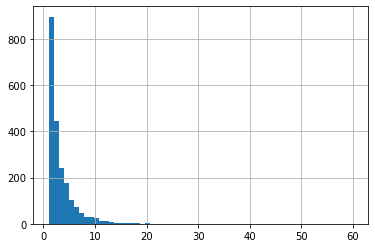

In [23]:
small_df.join(small_df['result'].apply(pd.Series))['SDG_2'].hist(bins=60)